# Pirate Pain Prediction: Multi-Model Sequence Classification

This notebook implements various deep learning models for predicting pirate pain levels from sequential motion data.

## 1. Environment Setup and Configuration

In [1]:
import json
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from scipy.ndimage import gaussian_filter1d
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import GroupKFold

# Set random seeds for reproducibility
SEED = 5555656
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Directory Structure Setup

In [3]:
# Create necessary directories
DATA_DIR = "dataset"
PRED_DIR = "prediction"
MODELS_DIR = "models"
BEST_PARAM_DIR = "best_param"

os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(BEST_PARAM_DIR, exist_ok=True)

timestamp = time.strftime("%Y%m%d-%H%M%S")
CHECKPOINT_DIR = os.path.join(MODELS_DIR, timestamp, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Experiment timestamp: {timestamp}")

Experiment timestamp: 20251117-181923


## 3. Hyperparameter Configuration

In [44]:
# Model and training configuration
MODEL_TYPE = "Ensemble"  # Options: LSTM / GRU / Transformer / CNN1D / MLP / Ensemble / GNN
BATCH_SIZE = 64
NUM_EPOCHS = 75
LR = 1e-3
VALID_SPLIT = 0.2
EARLY_STOPPING_PATIENCE = 20
PREPROCESSING_VISUAL_CHECK = False

# Preprocessing configurations
PREPROCESSING_OPTS = {
    "gaussian": "none",
    "exp": "min+asinh", 
    "pain": "none"
}

SCALER_OPTS = {
    "gaussian": "standard",
    "exp": "none",
    "pain": "none"
}

epsilon = 1e-6
print(f"Model type: {MODEL_TYPE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LR}")

Model type: Ensemble
Batch size: 64
Learning rate: 0.001


## 4. Data Loading and Initial Processing

In [9]:
# Load datasets
X_train = pd.read_csv(os.path.join(DATA_DIR, "pirate_pain_train.csv"))
y_train = pd.read_csv(os.path.join(DATA_DIR, "pirate_pain_train_labels.csv"))
X_test = pd.read_csv(os.path.join(DATA_DIR, "pirate_pain_test.csv"))

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Labels shape: {y_train.shape}")

# One-hot encode categorical features
categorical_cols = ['n_legs', 'n_hands', 'n_eyes']
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# Drop constant column
for c in ['joint_30']:
    if c in X_train_enc.columns:
        X_train_enc.drop(columns=[c], inplace=True)
        X_test_enc.drop(columns=[c], inplace=True)

# Define feature groups based on distribution types
pain_cols = [f"pain_survey_{i}" for i in range(1, 5)]
gaussian_joints = [f"joint_{i:02d}" for i in range(0, 13)] + [f"joint_{i}" for i in range(26, 30)]
exp_joints = [f"joint_{i}" for i in range(13, 26)]
onehot_cols = [c for c in X_train_enc.columns if any(k in c for k in ['n_legs_', 'n_hands_', 'n_eyes_'])]

print(f"Pain columns: {len(pain_cols)}")
print(f"Gaussian joints: {len(gaussian_joints)}")
print(f"Exponential joints: {len(exp_joints)}")
print(f"One-hot columns: {len(onehot_cols)}")

Training data shape: (105760, 40)
Test data shape: (211840, 40)
Labels shape: (661, 2)
Pain columns: 4
Gaussian joints: 17
Exponential joints: 13
One-hot columns: 6


## 5. Preprocessing Functions

In [11]:
def apply_preprocessing(X_train, X_test, cols, option):
    """Apply preprocessing per feature group."""
    X_train_mod, X_test_mod = X_train.copy(), X_test.copy()
    
    for col in cols:
        if col not in X_train_mod.columns:
            continue
            
        x_train, x_test = X_train_mod[col].values, X_test_mod[col].values
        min_val = x_train.min()
        x_train_shift = x_train - min_val + epsilon
        x_test_shift = x_test - min_val + epsilon
        
        # Apply chosen preprocessing
        if option == "gaussian":
            X_train_mod[col] = gaussian_filter1d(x_train, sigma=1)
            X_test_mod[col] = gaussian_filter1d(x_test, sigma=1)
        elif option == "min":
            X_train_mod[col] = x_train_shift
            X_test_mod[col] = x_test_shift
        elif option == "min+log":
            X_train_mod[col] = np.log(x_train_shift)
            X_test_mod[col] = np.log(x_test_shift)
        elif option == "min+asinh":
            X_train_mod[col] = np.arcsinh(x_train_shift)
            X_test_mod[col] = np.arcsinh(x_test_shift)
        elif option == "boxcox":
            pt = PowerTransformer(method='box-cox', standardize=False)
            X_train_mod[col] = pt.fit_transform(x_train_shift.reshape(-1, 1)).ravel()
            X_test_mod[col] = pt.transform(x_test_shift.reshape(-1, 1)).ravel()
        elif option == "none":
            pass  # leave as is
        else:
            raise ValueError(f"Unknown preprocessing option: {option}")
            
    return X_train_mod, X_test_mod

def apply_scaler(X_train, X_test, cols, option):
    """Apply scaling to feature groups."""
    if len(cols) == 0 or option == "none":
        return X_train, X_test
    
    if option == "standard":
        scaler = StandardScaler()
    elif option == "minmax":
        scaler = MinMaxScaler()
    elif option == "robust":
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaler: {option}")
    
    X_train[cols] = scaler.fit_transform(X_train[cols])
    X_test[cols] = scaler.transform(X_test[cols])
    return X_train, X_test

## 6. Preprocessing Pipeline

In [15]:
# Apply preprocessing pipeline
feature_cols = pain_cols + gaussian_joints + exp_joints + onehot_cols

# Global preprocessing for CV
X_train_full_for_cv = pd.get_dummies(X_train, columns=categorical_cols)
X_test_full_for_cv = pd.get_dummies(X_test, columns=categorical_cols)
X_test_full_for_cv = X_test_full_for_cv.reindex(columns=X_train_full_for_cv.columns, fill_value=0)

for c in ['joint_30']:
    if c in X_train_full_for_cv.columns:
        X_train_full_for_cv.drop(columns=[c], inplace=True)
        X_test_full_for_cv.drop(columns=[c], inplace=True)

# Global scaler
global_scaler = StandardScaler()
global_scaler.fit(X_train_full_for_cv[feature_cols])

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(sorted(y_train['label'].unique()))}
y_train['label_encoded'] = y_train['label'].map(label_mapping)

print("Preprocessing pipeline completed")
print(f"Total features: {len(feature_cols)}")
print(f"Label mapping: {label_mapping}")

Preprocessing pipeline completed
Total features: 40
Label mapping: {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}


## 7. Cross-Validation Data Preparation

In [18]:
# --------------------------
# Cross-Validation Data Preparation
# --------------------------

def prepare_cv_data(train_ids, val_ids):
    """Prepare data for cross-validation without data leakage"""
    tr_df = X_train[X_train['sample_index'].isin(train_ids)].copy()
    va_df = X_train[X_train['sample_index'].isin(val_ids)].copy()
    
    # One-hot encoding 
    tr_enc = pd.get_dummies(tr_df, columns=categorical_cols)
    va_enc = pd.get_dummies(va_df, columns=categorical_cols)
    va_enc = va_enc.reindex(columns=tr_enc.columns, fill_value=0)

    for c in ['joint_30']:
        if c in tr_enc.columns:
            tr_enc.drop(columns=[c], inplace=True)
            va_enc.drop(columns=[c], inplace=True)

    # Global preprocessing
    tr_pp = tr_enc.copy()
    va_pp = va_enc.copy()
    
    tr_pp[feature_cols] = global_scaler.transform(tr_enc[feature_cols])
    va_pp[feature_cols] = global_scaler.transform(va_enc[feature_cols])
    
    return tr_pp, va_pp

def make_fold_loaders(train_ids, val_ids):
    """Create data loaders for cross-validation folds"""
    tr_pp, va_pp = prepare_cv_data(train_ids, val_ids)
    
    onehot_cols_fold = [c for c in tr_pp.columns if any(k in c for k in ['n_legs_', 'n_hands_', 'n_eyes_'])]
    base_cols_fold = [c for c in (pain_cols + gaussian_joints + exp_joints) if c in tr_pp.columns]
    feature_cols_fold = base_cols_fold + onehot_cols_fold
    input_dim_fold = len(feature_cols_fold)
    
    ds_tr = PiratePainSeqDataset(tr_pp, y_train, feature_cols=feature_cols_fold)
    ds_va = PiratePainSeqDataset(va_pp, y_train, feature_cols=feature_cols_fold)
    
    train_loader = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, val_loader, input_dim_fold


## 8. Data Exploration and Validation


In [21]:
# --------------------------
# Data Exploration and Validation
# --------------------------

print("Final preprocessing summary:")
print(f"Pain cols: {pain_cols}")
print(f"Gaussian joints: {gaussian_joints}")
print(f"Exponential joints: {exp_joints}")
print(f"One-hot cols: {onehot_cols}")
print(f"Preprocessing: {PREPROCESSING_OPTS}")
print(f"Scalers: {SCALER_OPTS}")
print(f"Final feature columns ({len(feature_cols)}): {feature_cols[:10]} ...")

def analyze_features_for_group(df, feature_cols, group_ids, time_col='time', 
                              sample_idx_col='sample_index', save_plots=False, plot_dir="plots"):
    """Analyze feature distributions and temporal patterns for specific sample groups"""
    
    if isinstance(group_ids, (int, str)):
        group_ids = [group_ids]

    df_group = df[df[sample_idx_col].isin(group_ids)]

    if df_group.empty:
        print(f"No data found for groups {group_ids}")
        return {}

    if save_plots and not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    stats_summary = {}

    for col in feature_cols:
        print(f"\n--- Analysis for {col} (groups {group_ids}) ---")

        series = df_group[col]
        is_bool = set(series.unique()).issubset({0,1})

        stats = {}
        if is_bool:
            counts_0 = (series == 0).sum()
            counts_1 = (series == 1).sum()
            total = counts_0 + counts_1
            prop_0 = counts_0 / total if total > 0 else np.nan
            prop_1 = counts_1 / total if total > 0 else np.nan
            stats = {
                'counts_0': counts_0,
                'counts_1': counts_1,
                'prop_0': prop_0,
                'prop_1': prop_1
            }
        else:
            stats = {
                'min': series.min(),
                'max': series.max(),
                'mean': series.mean(),
                'median': series.median(),
                'std': series.std(),
                '25%': series.quantile(0.25),
                '75%': series.quantile(0.75),
            }

        stats_summary[col] = stats
        for k, v in stats.items():
            print(f"{k}: {v}")

        # Temporal plot
        plt.figure(figsize=(8,4))
        for idx, df_sub in df_group.groupby(sample_idx_col):
            plt.plot(df_sub[time_col], df_sub[col], label=f"{sample_idx_col}={idx}", alpha=0.8)
        plt.title(f"{col} over time for group(s) {group_ids}")
        plt.xlabel(time_col)
        plt.ylabel(col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(plot_dir, f"{col}_groups_{'_'.join(map(str, group_ids))}.png"))
        plt.show()

        # Distribution plot
        plt.figure(figsize=(6,4))
        if is_bool:
            sns.countplot(x=col, data=df_group)
        else:
            sns.histplot(series, bins=30, kde=True)
        plt.title(f"Distribution of {col} (group {group_ids})")
        plt.grid(True)
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(plot_dir, f"{col}_dist_groups_{'_'.join(map(str, group_ids))}.png"))
        plt.show()

    return stats_summary

# Execute data exploration if enabled
if PREPROCESSING_VISUAL_CHECK:
    print("\\n--- Running Data Exploration ---")
    stats_summary = analyze_features_for_group(X_train_enc, feature_cols, group_ids=4)
    
    print("\\n--- Dataset Shapes ---")
    print("X_train_enc shape:", X_train_enc.shape) 
    print("y_train label column:")
    print(y_train['label'].head())
    print("y_train encoded labels:")
    print(y_train['label_encoded'].unique())

    # Label distribution plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.countplot(x='label', data=y_train, ax=ax1)
    ax1.set_title("Distribution of Original Labels")
    ax1.grid(True)
    
    sns.countplot(x='label_encoded', data=y_train, ax=ax2)
    ax2.set_title("Distribution of Encoded Labels")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

Final preprocessing summary:
Pain cols: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Gaussian joints: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Exponential joints: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25']
One-hot cols: ['n_legs_one+peg_leg', 'n_legs_two', 'n_hands_one+hook_hand', 'n_hands_two', 'n_eyes_one+eye_patch', 'n_eyes_two']
Preprocessing: {'gaussian': 'none', 'exp': 'min+asinh', 'pain': 'none'}
Scalers: {'gaussian': 'standard', 'exp': 'none', 'pain': 'none'}
Final feature columns (40): ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05'] ...


## 9. Dataset and DataLoader Classes

In [24]:
class PiratePainSeqDataset(Dataset):
    """Custom Dataset for sequential pirate pain data."""
    
    def __init__(self, X, y=None, feature_cols=None):
        self.X, self.y = [], []
        self.sample_ids = []
        
        if feature_cols is None:
            onehot_cols_fold = [c for c in X.columns if any(k in c for k in ['n_legs_', 'n_hands_', 'n_eyes_'])]
            base_cols_fold = [c for c in (pain_cols + gaussian_joints + exp_joints) if c in X.columns]
            feature_cols = base_cols_fold + onehot_cols_fold
        
        self.feature_cols = feature_cols
        y_map = None
        
        if y is not None:
            y_map = y.set_index('sample_index')['label'].map(label_mapping)
        
        for idx, df_sub in X.groupby('sample_index'):
            seq = df_sub[self.feature_cols].values.astype(np.float32)
            self.X.append(seq)
            self.sample_ids.append(idx)
            
            if y_map is not None:
                if idx not in y_map.index:
                    raise ValueError(f"sample_index {idx} not found in y_train")
                self.y.append(y_map.loc[idx])
        
        print(f"Total sequences loaded: {len(self.X)}")
        
        if y is not None:
            self.y = np.array(self.y)
            print(f"Total labels loaded: {len(self.y)}")
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.y is not None:
            return x, torch.tensor(self.y[idx], dtype=torch.long)
        return x

def collate_fn(batch):
    """Collate function for padding sequences."""
    x, y = zip(*batch) if isinstance(batch[0], tuple) else (batch, None)
    x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True)
    
    if y is not None:
        y = torch.stack(y)
        return x_padded, y
    return x_padded

## 10. Model Architectures

In [27]:
class AttentivePooling1D(nn.Module):
    """Attention-based pooling for sequence models."""
    
    def __init__(self, input_dim):
        super().__init__()
        self.attention = nn.Linear(input_dim, 1)

    def forward(self, x):
        scores = self.attention(x)
        weights = F.softmax(scores, dim=1)
        x_pooled = (x * weights).sum(dim=1)
        return x_pooled

class LSTMModel(nn.Module):
    """LSTM model for sequence classification."""
    
    def __init__(self, input_dim, hidden_size, num_layers, num_classes, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_size, num_layers=num_layers, 
            batch_first=True, dropout=dropout, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class GRUModel(nn.Module):
    """GRU model with attention pooling."""
    
    def __init__(self, input_dim, hidden_size=512, num_layers=4, num_classes=10, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden_size, num_layers=num_layers, 
            batch_first=True, dropout=dropout, bidirectional=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.att_pool = AttentivePooling1D(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.layer_norm(out)
        out = self.att_pool(out)
        return self.fc(out)

class TransformerModel(nn.Module):
    """Transformer model for sequence classification."""
    
    def __init__(self, input_dim, num_classes, hidden_dim=192, nhead=4, num_layers=2, max_seq_len=500, dropout=0.4):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.pos_enc = nn.Parameter(torch.randn(1, max_seq_len, hidden_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dropout=dropout, 
            batch_first=True, dim_feedforward=hidden_dim*4, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.att_pool = AttentivePooling1D(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.input_fc(x)
        seq_len = x.size(1)
        x = x + self.pos_enc[:, :seq_len, :]
        x = self.transformer(x, src_key_padding_mask=mask)
        x = self.layer_norm(x)
        x = self.att_pool(x)
        x = self.dropout(x)
        return self.fc(x)

In [29]:
class SEBlock1D(nn.Module):
    """Squeeze-and-Excitation block for 1D CNNs."""
    
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        y = x.mean(dim=2)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).unsqueeze(-1)
        return x * y

class ResidualBlock1D(nn.Module):
    """Residual block for 1D CNNs."""
    
    def __init__(self, in_channels, out_channels, kernel_size, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.se = SEBlock1D(out_channels)
        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

class CNN1DModel(nn.Module):
    """1D CNN model with residual blocks and SE attention."""
    
    def __init__(self, input_dim, num_classes, conv_channels, kernel_sizes, dropout=0.3):
        super().__init__()
        layers = []
        in_channels = input_dim
        
        for out_channels, k in zip(conv_channels, kernel_sizes):
            layers.append(ResidualBlock1D(in_channels, out_channels, k, dropout))
            in_channels = out_channels
        
        layers.append(nn.AdaptiveMaxPool1d(1))
        self.conv = nn.Sequential(*layers)
        self.fc = nn.Linear(conv_channels[-1], num_classes)

    def forward(self, x):
        x = x.transpose(1,2)
        x = self.conv(x)
        x = x.squeeze(-1)
        return self.fc(x)

class MLPModel(nn.Module):
    """Multi-Layer Perceptron model."""
    
    def __init__(self, input_dim, hidden_sizes, num_classes, dropout):
        super().__init__()
        layers = []
        in_dim = input_dim
        
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.mean(dim=1)
        return self.net(x)

In [31]:
class GNNModel(nn.Module):
    """Graph Neural Network model for sequence data."""
    
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, heads=4, dropout=0.3):
        super().__init__()
        self.num_layers = num_layers
        self.heads = heads
        self.dropout = dropout
        
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout, concat=True))
        
        for _ in range(num_layers-1):
            self.convs.append(GATConv(hidden_dim*heads, hidden_dim, heads=heads, dropout=dropout, concat=True))
        
        self.relu = nn.ReLU()
        self.att_pool = AttentivePooling1D(hidden_dim*heads)
        self.fc = nn.Linear(hidden_dim*heads, num_classes)

    def forward(self, x):
        batch_size, seq_len, feat_dim = x.size()
        device = x.device
        
        # Create temporal edges
        edge_indices = []
        for b in range(batch_size):
            row = torch.arange(seq_len-1, device=device) + b*seq_len
            col = torch.arange(1, seq_len, device=device) + b*seq_len
            edge_index = torch.stack([torch.cat([row, col]), torch.cat([col, row])], dim=0)
            edge_indices.append(edge_index)
        
        edge_index = torch.cat(edge_indices, dim=1)
        x = x.reshape(batch_size*seq_len, feat_dim)
        
        # Apply GNN layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = x.view(batch_size, seq_len, -1)
        x = self.att_pool(x)
        return self.fc(x)

class EnsembleModel(nn.Module):
    """Ensemble of multiple models with learnable weights."""
    
    def __init__(self, input_dim, num_classes, device, model_configs=None):
        super().__init__()
        self.device = device
        
        if model_configs is None:
            model_configs = {
                "cnn": {"conv_channels": [48, 96, 160], "kernel_sizes": [5, 3, 3], "dropout": 0.4},
                "gru": {"hidden_size": 192, "num_layers": 3, "dropout": 0.4},
                "lstm": {"hidden_size": 192, "num_layers": 3, "dropout": 0.4},
                "transformer": {"hidden_dim": 96, "nhead": 2, "num_layers": 3, "dropout": 0.3},
                "mlp": {"hidden_sizes": [384, 192, 128], "dropout": 0.4}
            }
        
        # Initialize individual models
        self.cnn = CNN1DModel(
            input_dim=input_dim, num_classes=num_classes,
            conv_channels=model_configs["cnn"]["conv_channels"],
            kernel_sizes=model_configs["cnn"]["kernel_sizes"],
            dropout=model_configs["cnn"]["dropout"]
        )
        
        self.gru = GRUModel(
            input_dim=input_dim, hidden_size=model_configs["gru"]["hidden_size"],
            num_layers=model_configs["gru"]["num_layers"], num_classes=num_classes,
            dropout=model_configs["gru"]["dropout"]
        )
        
        self.lstm = LSTMModel(
            input_dim=input_dim, hidden_size=model_configs["lstm"]["hidden_size"],
            num_layers=model_configs["lstm"]["num_layers"], num_classes=num_classes,
            dropout=model_configs["lstm"]["dropout"]
        )
        
        self.transformer = TransformerModel(
            input_dim=input_dim, num_classes=num_classes,
            hidden_dim=model_configs["transformer"]["hidden_dim"],
            nhead=model_configs["transformer"]["nhead"],
            num_layers=model_configs["transformer"]["num_layers"],
            max_seq_len=500, dropout=model_configs["transformer"]["dropout"]
        )
        
        self.mlp = MLPModel(
            input_dim=input_dim, hidden_sizes=model_configs["mlp"]["hidden_sizes"],
            num_classes=num_classes, dropout=model_configs["mlp"]["dropout"]
        )
        
        # Learnable ensemble weights
        self.model_weights = nn.Parameter(torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]), requires_grad=True)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        out_cnn = self.cnn(x)
        out_gru = self.gru(x)
        out_lstm = self.lstm(x)
        out_trans = self.transformer(x)
        out_mlp = self.mlp(x)
        
        logits = torch.stack([out_cnn, out_gru, out_lstm, out_trans, out_mlp], dim=1)
        weights = self.softmax(self.model_weights).unsqueeze(0).unsqueeze(-1)
        weighted_logits = (logits * weights).sum(dim=1)
        
        return weighted_logits

## 11. Configuration Management 


In [34]:
# --------------------------
# Configuration Management
# --------------------------

def load_best_configs_for_ensemble():
    """Load best configurations for each model type to build ensemble."""
    name_map = {
        "CNN1D": "cnn",
        "GRU": "gru", 
        "LSTM": "lstm",
        "Transformer": "transformer",
        "MLP": "mlp",
    }
    
    default_configs = {
        "cnn": {"conv_channels": [48, 96, 160], "kernel_sizes": [5, 3, 3], "dropout": 0.4},
        "gru": {"hidden_size": 192, "num_layers": 3, "dropout": 0.4},
        "lstm": {"hidden_size": 192, "num_layers": 3, "dropout": 0.4},
        "transformer": {"hidden_dim": 96, "nhead": 2, "num_layers": 3, "dropout": 0.3},
        "mlp": {"hidden_sizes": [384, 192, 128], "dropout": 0.4},
    }

    model_configs = {}
    
    for mt, key in name_map.items():
        cfg_path = os.path.join(BEST_PARAM_DIR, f"best_cfg_{mt}.json")
        if os.path.exists(cfg_path):
            with open(cfg_path, "r") as f:
                loaded = json.load(f)
            
            # Load configuration based on model type
            if key == "cnn":
                model_configs[key] = {
                    "conv_channels": loaded.get("conv_channels", default_configs[key]["conv_channels"]),
                    "kernel_sizes": loaded.get("kernel_sizes", default_configs[key]["kernel_sizes"]),
                    "dropout": loaded.get("dropout", default_configs[key]["dropout"]),
                }
            elif key in ("gru", "lstm"):
                model_configs[key] = {
                    "hidden_size": loaded.get("hidden_size", default_configs[key]["hidden_size"]),
                    "num_layers": loaded.get("num_layers", default_configs[key]["num_layers"]),
                    "dropout": loaded.get("dropout", default_configs[key]["dropout"]),
                }
            elif key == "transformer":
                model_configs[key] = {
                    "hidden_dim": loaded.get("hidden_dim", default_configs[key]["hidden_dim"]),
                    "nhead": loaded.get("nhead", default_configs[key]["nhead"]),
                    "num_layers": loaded.get("num_layers", default_configs[key]["num_layers"]),
                    "dropout": loaded.get("dropout", default_configs[key]["dropout"]),
                }
            elif key == "mlp":
                model_configs[key] = {
                    "hidden_sizes": loaded.get("hidden_sizes", default_configs[key]["hidden_sizes"]),
                    "dropout": loaded.get("dropout", default_configs[key]["dropout"]),
                }
            print(f"Loaded best config for {mt} -> key '{key}'")
        else:
            print(f"Warning: No best config found for {mt}, using defaults")
            model_configs[key] = default_configs[key]

    return model_configs

def save_best_config(model_type, best_cfg):
    """Save the best configuration for a model type to JSON file."""
    config_file = os.path.join(BEST_PARAM_DIR, f"best_cfg_{model_type}.json")
    with open(config_file, 'w') as f:
        json.dump(best_cfg, f, indent=2)
    print(f"Best configuration for {model_type} saved at: {config_file}")

## 12. Training Utilities

In [37]:
def build_model_by_type(cfg=None, input_dim=None, num_classes_arg=None):
    """Factory function to build models based on configuration."""
    if cfg is None:
        cfg = {}
    
    mtype = cfg.get("type", MODEL_TYPE)
    
    if num_classes_arg is None:
        num_classes_arg = len(label_mapping)
    
    if input_dim is None:
        raise ValueError("build_model_by_type requires input_dim to construct correct layers.")
    
    # Build specific model type
    if mtype == "LSTM":
        return LSTMModel(input_dim, cfg.get("hidden_size",192), cfg.get("num_layers",3), 
                       num_classes_arg, cfg.get("dropout",0.4)).to(device)
    
    elif mtype == "GRU":
        return GRUModel(input_dim, cfg.get("hidden_size",192), cfg.get("num_layers",3), 
                      num_classes_arg, cfg.get("dropout",0.4)).to(device)
    
    elif mtype == "Transformer":
        return TransformerModel(input_dim, num_classes_arg, cfg.get("hidden_dim",96), 
                              cfg.get("nhead",2), cfg.get("num_layers",3), 500, 
                              cfg.get("dropout",0.3)).to(device)
    
    elif mtype == "CNN1D":
        return CNN1DModel(input_dim, num_classes_arg, cfg.get("conv_channels",[48,96,160]), 
                        cfg.get("kernel_sizes",[5,3,3]), cfg.get("dropout",0.4)).to(device)
    
    elif mtype == "MLP":
        return MLPModel(input_dim, cfg.get("hidden_sizes",[384,192,128]), 
                      num_classes_arg, cfg.get("dropout",0.4)).to(device)
    
    elif mtype == "GNN":
        return GNNModel(input_dim=input_dim, hidden_dim=cfg.get("hidden_dim", 128), 
                      num_classes=num_classes_arg, num_layers=cfg.get("num_layers", 2), 
                      heads=cfg.get("heads", 4), dropout=cfg.get("dropout", 0.3)).to(device)
    
    elif mtype == "Ensemble":
        model_configs = load_best_configs_for_ensemble()
        return EnsembleModel(input_dim, num_classes_arg, device, model_configs).to(device)
    
    raise ValueError("MODEL_TYPE not supported")

def train_one_epoch(model, loader, optimizer, criterion):
    """Train model for one epoch."""
    model.train()
    total_loss = 0.0
    
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def eval_f1(model, loader, criterion):
    """Evaluate model and return metrics."""
    model.eval()
    vloss = 0.0
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            vloss += criterion(logits, yb).item()
            
            predictions.append(logits.argmax(1).cpu().numpy())
            true_labels.append(yb.cpu().numpy())
    
    vloss /= len(loader)
    y_pred = np.concatenate(predictions)
    y_true = np.concatenate(true_labels)
    
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    return vloss, f1, accuracy, precision, recall

## 13. Cross-Validation and Hyperparameter Tuning

In [40]:
# Prepare cross-validation
seq_ids = np.array(sorted(X_train['sample_index'].unique()))
y_seq = y_train.set_index('sample_index').loc[seq_ids, 'label'].map(label_mapping).values
groups = seq_ids.copy()

K = 10
gkf = GroupKFold(n_splits=K)

# ===== Hyperparameter Grids =====
all_param_grid = [
    # ---------- MLP ----------
    {"type": "MLP", "hidden_sizes": [256,128],       "dropout": 0.3, "lr": 1e-3},
    {"type": "MLP", "hidden_sizes": [384,192,128],   "dropout": 0.4, "lr": 1e-3},
    {"type": "MLP", "hidden_sizes": [512,256,128],   "dropout": 0.4, "lr": 1e-3},
    {"type": "MLP", "hidden_sizes": [512,256,128,64],"dropout": 0.5, "lr": 1e-3},
    {"type": "MLP", "hidden_sizes": [256,128],       "dropout": 0.3, "lr": 5e-4},

    # ---------- GRU ----------
    {"type": "GRU", "hidden_size": 128, "num_layers": 2, "dropout": 0.3, "lr": 1e-3},
    {"type": "GRU", "hidden_size": 192, "num_layers": 3, "dropout": 0.4, "lr": 1e-3},
    {"type": "GRU", "hidden_size": 256, "num_layers": 2, "dropout": 0.4, "lr": 5e-4},
    {"type": "GRU", "hidden_size": 256, "num_layers": 3, "dropout": 0.5, "lr": 1e-3},
    {"type": "GRU", "hidden_size": 320, "num_layers": 3, "dropout": 0.4, "lr": 5e-4},

    # ---------- LSTM ----------
    {"type": "LSTM", "hidden_size": 128, "num_layers": 2, "dropout": 0.3, "lr": 1e-3},
    {"type": "LSTM", "hidden_size": 192, "num_layers": 3, "dropout": 0.4, "lr": 1e-3},
    {"type": "LSTM", "hidden_size": 256, "num_layers": 2, "dropout": 0.4, "lr": 5e-4},
    {"type": "LSTM", "hidden_size": 320, "num_layers": 3, "dropout": 0.4, "lr": 5e-4},
    {"type": "LSTM", "hidden_size": 192, "num_layers": 4, "dropout": 0.5, "lr": 1e-3},

    # ---------- CNN1D ----------
    {"type": "CNN1D", "conv_channels": [32,64,128],     "kernel_sizes": [5,3,3], "dropout": 0.3, "lr": 1e-3},
    {"type": "CNN1D", "conv_channels": [48,96,160],     "kernel_sizes": [5,3,3], "dropout": 0.4, "lr": 1e-3},
    {"type": "CNN1D", "conv_channels": [64,128,256],    "kernel_sizes": [5,3,3], "dropout": 0.5, "lr": 5e-4},
    {"type": "CNN1D", "conv_channels": [64,128,256,512],"kernel_sizes": [7,5,3,3], "dropout": 0.4, "lr": 5e-4},

    # ---------- TRANSFORMER ----------
    {"type": "Transformer", "hidden_dim": 96,  "nhead": 2, "num_layers": 3, "dropout": 0.3, "lr": 5e-4},
    {"type": "Transformer", "hidden_dim": 128, "nhead": 4, "num_layers": 3, "dropout": 0.4, "lr": 5e-4},
    {"type": "Transformer", "hidden_dim": 192, "nhead": 4, "num_layers": 4, "dropout": 0.4, "lr": 5e-4},
    {"type": "Transformer", "hidden_dim": 256, "nhead": 8, "num_layers": 4, "dropout": 0.4, "lr": 3e-4},
    {"type": "Transformer", "hidden_dim": 128, "nhead": 4, "num_layers": 2, "dropout": 0.3, "lr": 1e-3},

    # ---------- GNN ----------
    {"type": "GNN", "hidden_dim": 96,  "num_layers": 2, "heads": 4, "dropout": 0.3, "lr": 1e-3},
    {"type": "GNN", "hidden_dim": 128, "num_layers": 2, "heads": 4, "dropout": 0.3, "lr": 1e-3},
    {"type": "GNN", "hidden_dim": 128, "num_layers": 3, "heads": 4, "dropout": 0.3, "lr": 5e-4},
    {"type": "GNN", "hidden_dim": 192, "num_layers": 3, "heads": 4, "dropout": 0.4, "lr": 5e-4},
    {"type": "GNN", "hidden_dim": 192, "num_layers": 2, "heads": 8, "dropout": 0.3, "lr": 3e-4},

    # ---------- ENSEMBLE ----------
    {"type": "Ensemble", "lr": 1e-3},
    {"type": "Ensemble", "lr": 5e-4},
    {"type": "Ensemble", "lr": 1e-4},
]

# Filter grid for current model type
param_grid = [cfg for cfg in all_param_grid if cfg["type"] == MODEL_TYPE]

print(f"\nHyperparameter tuning for MODEL_TYPE = {MODEL_TYPE}")
print(f"Found {len(param_grid)} configurations.")

# Initialize best results tracking
best_cfg, best_mean_f1 = None, -1.0
best_std_f1 = None
best_mean_acc = best_std_acc = None
best_mean_prec = best_std_prec = None
best_mean_rec = best_std_rec = None

# Cross-validation loop
for cfg in param_grid:
    fold_f1_scores = []
    fold_acc_scores = []
    fold_prec_scores = []
    fold_rec_scores = []

    print(f"\n--- Testing configuration: {cfg} ---")
    
    for fold, (tr_idx, va_idx) in enumerate(gkf.split(seq_ids, y_seq, groups=groups)):
        train_ids = seq_ids[tr_idx]
        val_ids = seq_ids[va_idx]
        
        # Create data loaders for this fold
        train_loader, val_loader, input_dim_fold = make_fold_loaders(train_ids, val_ids)

        # Build model with current configuration
        model = build_model_by_type(cfg, input_dim=input_dim_fold)
        lr = cfg.get("lr", LR if cfg["type"] != "Transformer" else LR * 0.5)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=0.3,
            patience=(3 if cfg["type"] == "Transformer" else 5),
            min_lr=1e-7
        )

        # Training loop with early stopping
        best_vloss, wait, best_state = float('inf'), 0, None
        
        for epoch in range(1, NUM_EPOCHS + 1):
            _ = train_one_epoch(model, train_loader, optimizer, criterion)
            vloss, vf1, vacc, vprec, vrec = eval_f1(model, val_loader, criterion)
            scheduler.step(vloss)

            if vloss < best_vloss - 1e-4:
                best_vloss, wait = vloss, 0
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            else:
                wait += 1
                if wait >= EARLY_STOPPING_PATIENCE:
                    break

        # Load best model and evaluate
        model.load_state_dict(best_state)
        _, vf1, vacc, vprec, vrec = eval_f1(model, val_loader, criterion)

        fold_f1_scores.append(vf1)
        fold_acc_scores.append(vacc)
        fold_prec_scores.append(vprec)
        fold_rec_scores.append(vrec)

        print(f"Fold {fold+1}/{K}: F1={vf1:.4f} | Acc={vacc:.4f} | Prec={vprec:.4f} | Rec={vrec:.4f}")

    # Calculate mean and std for this configuration
    mean_f1 = float(np.mean(fold_f1_scores))
    std_f1 = float(np.std(fold_f1_scores))
    mean_acc = float(np.mean(fold_acc_scores))
    std_acc = float(np.std(fold_acc_scores))
    mean_prec = float(np.mean(fold_prec_scores))
    std_prec = float(np.std(fold_prec_scores))
    mean_rec = float(np.mean(fold_rec_scores))
    std_rec = float(np.std(fold_rec_scores))

    print(f"Configuration {cfg} => "
          f"F1: {mean_f1:.4f} ± {std_f1:.4f} | "
          f"Acc: {mean_acc:.4f} ± {std_acc:.4f} | "
          f"Prec: {mean_prec:.4f} ± {std_prec:.4f} | "
          f"Rec: {mean_rec:.4f} ± {std_rec:.4f}")

    # Update best configuration
    if mean_f1 > best_mean_f1:
        best_mean_f1, best_cfg = mean_f1, cfg
        best_std_f1 = std_f1
        best_mean_acc, best_std_acc = mean_acc, std_acc
        best_mean_prec, best_std_prec = mean_prec, std_prec
        best_mean_rec, best_std_rec = mean_rec, std_rec

# Display best results
print("\n" + "="*60)
print(">>> BEST CONFIGURATION FOUND:")
print(best_cfg)
print("\nCross-Validation Performance (macro metrics):")
print(f"  F1 Score  : {best_mean_f1:.4f} ± {best_std_f1:.4f}")
print(f"  Accuracy  : {best_mean_acc:.4f} ± {best_std_acc:.4f}")
print(f"  Precision : {best_mean_prec:.4f} ± {best_std_prec:.4f}")
print(f"  Recall    : {best_mean_rec:.4f} ± {best_std_rec:.4f}")
print("="*60)

# Save best configuration
if MODEL_TYPE != "Ensemble":
    save_best_config(MODEL_TYPE, best_cfg)

# Save best configuration in models folder
os.makedirs(os.path.join(MODELS_DIR, timestamp), exist_ok=True)
with open(os.path.join(MODELS_DIR, timestamp, "best_cfg.json"), "w") as f:
    json.dump(best_cfg, f, indent=2)


Hyperparameter tuning for MODEL_TYPE = Ensemble
Found 3 configurations.

--- Testing configuration: {'type': 'Ensemble', 'lr': 0.001} ---
Total sequences loaded: 594
Total labels loaded: 594
Total sequences loaded: 67
Total labels loaded: 67
Loaded best config for CNN1D -> key 'cnn'
Loaded best config for GRU -> key 'gru'
Loaded best config for LSTM -> key 'lstm'
Loaded best config for Transformer -> key 'transformer'
Loaded best config for MLP -> key 'mlp'


C:\Users\Francesco\anaconda3\envs\pirate-pain\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Fold 1/10: F1=0.9492 | Acc=0.9851 | Prec=0.9937 | Rec=0.9167
Total sequences loaded: 595
Total labels loaded: 595
Total sequences loaded: 66
Total labels loaded: 66
Loaded best config for CNN1D -> key 'cnn'
Loaded best config for GRU -> key 'gru'
Loaded best config for LSTM -> key 'lstm'
Loaded best config for Transformer -> key 'transformer'
Loaded best config for MLP -> key 'mlp'
Fold 2/10: F1=0.6675 | Acc=0.8333 | Prec=0.6875 | Rec=0.6511
Total sequences loaded: 595
Total labels loaded: 595
Total sequences loaded: 66
Total labels loaded: 66
Loaded best config for CNN1D -> key 'cnn'
Loaded best config for GRU -> key 'gru'
Loaded best config for LSTM -> key 'lstm'
Loaded best config for Transformer -> key 'transformer'
Loaded best config for MLP -> key 'mlp'
Fold 3/10: F1=0.7503 | Acc=0.8788 | Prec=0.7511 | Rec=0.7639
Total sequences loaded: 595
Total labels loaded: 595
Total sequences loaded: 66
Total labels loaded: 66
Loaded best config for CNN1D -> key 'cnn'
Loaded best config for 

## 14. Final Model Training


Applying final preprocessing on full dataset...
Final feature dimension: 40
Number of classes: 3
Total sequences loaded: 661
Total labels loaded: 661
Total sequences loaded: 1324

Training final model with best configuration...
Loaded best config for CNN1D -> key 'cnn'
Loaded best config for GRU -> key 'gru'
Loaded best config for LSTM -> key 'lstm'
Loaded best config for Transformer -> key 'transformer'
Loaded best config for MLP -> key 'mlp'
Starting final training...
[FINAL TRAINING] Epoch 5/75 - Train Loss: 0.3489
[FINAL TRAINING] Epoch 10/75 - Train Loss: 0.1740
[FINAL TRAINING] Epoch 15/75 - Train Loss: 0.0971
[FINAL TRAINING] Epoch 20/75 - Train Loss: 0.0746
[FINAL TRAINING] Epoch 25/75 - Train Loss: 0.0443
[FINAL TRAINING] Epoch 30/75 - Train Loss: 0.0249
[FINAL TRAINING] Epoch 35/75 - Train Loss: 0.0786
[FINAL TRAINING] Epoch 40/75 - Train Loss: 0.0360
[FINAL TRAINING] Epoch 45/75 - Train Loss: 0.0389
[FINAL TRAINING] Epoch 50/75 - Train Loss: 0.0343
[FINAL TRAINING] Epoch 55/

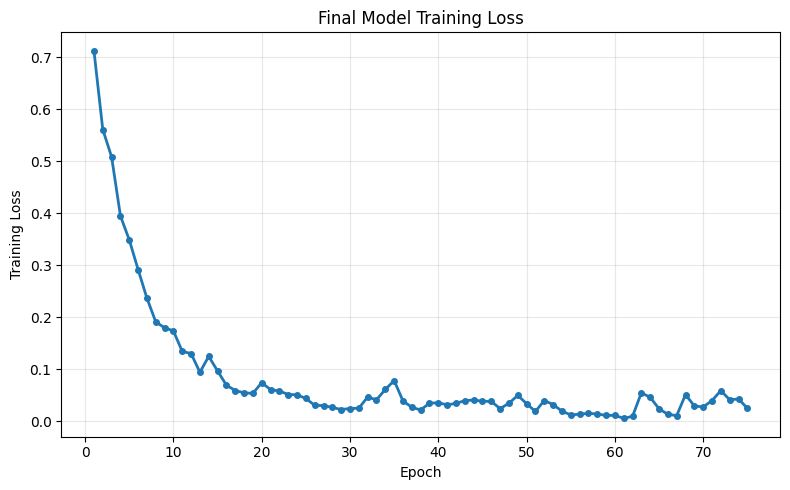

Training loss plot saved to: models\20251117-181923\final_training_loss.png
Hyperparameters saved to: models\20251117-181923\hyperparameters.json


In [46]:
# ===== Final Preprocessing on Full Dataset =====
print("Applying final preprocessing on full dataset...")

# One-hot encoding on full dataset
X_train_full_enc = pd.get_dummies(X_train, columns=categorical_cols)
X_test_full_enc = pd.get_dummies(X_test, columns=categorical_cols)
X_test_full_enc = X_test_full_enc.reindex(columns=X_train_full_enc.columns, fill_value=0)

# Remove constant column
for c in ['joint_30']:
    if c in X_train_full_enc.columns:
        X_train_full_enc.drop(columns=[c], inplace=True)
        X_test_full_enc.drop(columns=[c], inplace=True)

# Apply preprocessing pipeline to full dataset
X_train_full_pp, X_test_full_pp = apply_preprocessing(
    X_train_full_enc, X_test_full_enc, gaussian_joints, PREPROCESSING_OPTS["gaussian"]
)
X_train_full_pp, X_test_full_pp = apply_scaler(
    X_train_full_pp, X_test_full_pp, gaussian_joints, SCALER_OPTS["gaussian"]
)

X_train_full_pp, X_test_full_pp = apply_preprocessing(
    X_train_full_pp, X_test_full_pp, exp_joints, PREPROCESSING_OPTS["exp"]
)
X_train_full_pp, X_test_full_pp = apply_scaler(
    X_train_full_pp, X_test_full_pp, exp_joints, SCALER_OPTS["exp"]
)

X_train_full_pp, X_test_full_pp = apply_preprocessing(
    X_train_full_pp, X_test_full_pp, pain_cols, PREPROCESSING_OPTS["pain"]
)
X_train_full_pp, X_test_full_pp = apply_scaler(
    X_train_full_pp, X_test_full_pp, pain_cols, SCALER_OPTS["pain"]
)

# Define final feature columns
onehot_cols_full = [c for c in X_train_full_pp.columns if any(k in c for k in ['n_legs_', 'n_hands_', 'n_eyes_'])]
base_cols_full = [c for c in (pain_cols + gaussian_joints + exp_joints) if c in X_train_full_pp.columns]
feature_cols_full = base_cols_full + onehot_cols_full
input_dim_full = len(feature_cols_full)
num_classes = len(label_mapping)

print(f"Final feature dimension: {input_dim_full}")
print(f"Number of classes: {num_classes}")

# Create final datasets and data loaders
final_train_ds = PiratePainSeqDataset(X_train_full_pp, y_train, feature_cols=feature_cols_full)
test_dataset = PiratePainSeqDataset(X_test_full_pp, feature_cols=feature_cols_full)

final_train_loader = DataLoader(final_train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# ===== Train Final Model with Best Configuration =====
print(f"\nTraining final model with best configuration...")
model = build_model_by_type(best_cfg, input_dim=input_dim_full, num_classes_arg=num_classes)
lr = best_cfg.get("lr", LR if best_cfg["type"] != "Transformer" else LR * 0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Final training with logging
print("Starting final training...")
final_logs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss_epoch = train_one_epoch(model, final_train_loader, optimizer, criterion)
    final_logs.append({"epoch": epoch, "train_loss": train_loss_epoch})
    
    if epoch % 5 == 0:
        print(f"[FINAL TRAINING] Epoch {epoch}/{NUM_EPOCHS} - Train Loss: {train_loss_epoch:.4f}")

# Plot training loss
if len(final_logs) > 0:
    logs_df = pd.DataFrame(final_logs)
    plt.figure(figsize=(8, 5))
    plt.plot(logs_df['epoch'], logs_df['train_loss'], marker='o', linewidth=2, markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Final Model Training Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plot_path = os.path.join(MODELS_DIR, timestamp, "final_training_loss.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Training loss plot saved to: {plot_path}")

# Save hyperparameters
hyperparameters = {
    "MODEL_TYPE": MODEL_TYPE,
    "BATCH_SIZE": BATCH_SIZE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "LR": LR,
    "VALID_SPLIT": VALID_SPLIT,
    "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
    "PREPROCESSING_OPTS": PREPROCESSING_OPTS,
    "SCALER_OPTS": SCALER_OPTS,
    "epsilon": epsilon,
    "best_configuration": best_cfg,
    "cv_performance": {
        "f1_score": f"{best_mean_f1:.4f} ± {best_std_f1:.4f}",
        "accuracy": f"{best_mean_acc:.4f} ± {best_std_acc:.4f}",
        "precision": f"{best_mean_prec:.4f} ± {best_std_prec:.4f}",
        "recall": f"{best_mean_rec:.4f} ± {best_std_rec:.4f}"
    }
}

hyperparams_path = os.path.join(MODELS_DIR, timestamp, "hyperparameters.json")
with open(hyperparams_path, 'w') as f:
    json.dump(hyperparameters, f, indent=4)
print(f"Hyperparameters saved to: {hyperparams_path}")

## 15. Prediction and Submission

In [48]:
# ===== Generate Predictions =====
print("Generating predictions on test set...")

label_map = {v: k for k, v in label_mapping.items()}

model.eval()
predictions = []

with torch.no_grad():
    for X_batch in tqdm(test_loader, desc="Predicting"):
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.argmax(1).cpu().numpy())

# Process predictions
predictions = np.concatenate(predictions)
predicted_labels = [label_map[p] for p in predictions]

# Get sample indices from test set
sample_indices = X_test['sample_index'].drop_duplicates().reset_index(drop=True)
sample_indices_str = sample_indices.apply(lambda x: f"{x:03d}")

# Create submission dataframe
submission = pd.DataFrame({
    "sample_index": sample_indices_str,
    "label": predicted_labels
})

# Save submission file
submission_path = os.path.join(PRED_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)

print(f" File saved at: {submission_path}")
print(submission['label'].value_counts().sort_index())

# Display sample of submission
print("\n Sample of submission file:")
print(submission.head(10))

# Save model if desired
model_save_path = os.path.join(MODELS_DIR, timestamp, "final_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'best_config': best_cfg,
    'feature_cols': feature_cols_full,
    'label_mapping': label_mapping
}, model_save_path)
print(f"\n💾 Model saved to: {model_save_path}")

Generating predictions on test set...


Predicting: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.42it/s]


 File saved at: prediction\submission.csv
label
high_pain     150
low_pain      153
no_pain      1021
Name: count, dtype: int64

 Sample of submission file:
  sample_index      label
0          000    no_pain
1          001    no_pain
2          002    no_pain
3          003    no_pain
4          004    no_pain
5          005  high_pain
6          006    no_pain
7          007    no_pain
8          008    no_pain
9          009    no_pain

💾 Model saved to: models\20251117-181923\final_model.pth


## Summary

This notebook provides a comprehensive framework for pirate pain prediction using multiple deep learning architectures. Key features include:

- Data preprocessing and feature engineering
- Multiple model architectures (LSTM, GRU, Transformer, CNN1D, MLP, GNN, Ensemble)
- Cross-validation and hyperparameter tuning
- Attention mechanisms and advanced pooling techniques
- Comprehensive evaluation metrics

The implementation is modular and allows easy switching between different model types through configuration changes.